# Analyse data distributions

This notebook is made to analyse the distribution of each explanatory variable regarding our tennis data samples

### imports

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="darkgrid", palette="deep")

### Get Data

In [2]:
path_to_data = "../data"
path_to_processed_data = os.path.join(path_to_data, "processed")
path_df = os.path.join(path_to_processed_data, "tennis_merged.csv") 

In [3]:
df = pd.read_csv(path_df)

### Visualize data

In [4]:
df.coupon_discount.unique()

array([ 0.,  5., 11., 10., 15.,  8.])

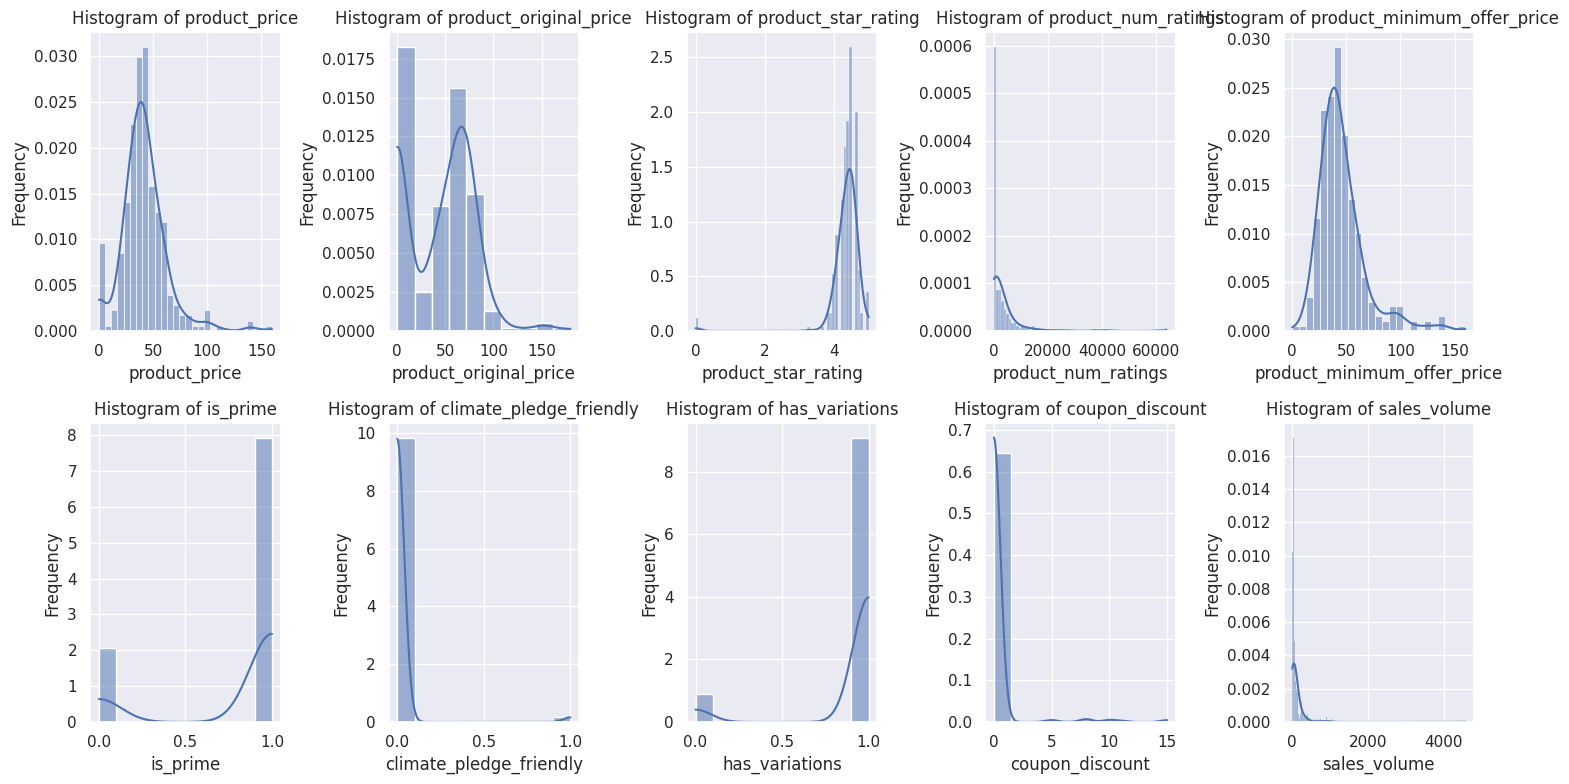

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # Tamaño ajustado para la cuadrícula
axes = axes.ravel()  # Convertimos los ejes a un array 1D para iterar fácilmente

# Iterar sobre las columnas y graficar los histogramas
for i, column in enumerate(df.select_dtypes(include='number').columns):
    #axes[i].hist(df[column], bins=30, color="b")
    sns.histplot(data=df, x=column, stat="density", ax=axes[i], kde=True)
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Eliminar cualquier gráfico vacío (si hay más espacios que columnas)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Hypothesize distributions

In [6]:
hypothesized_distributions = {        
    'product_price': 'non-symmetric bimodal', 
    'product_original_price': 'symmetric bimodal', 
    'product_star_rating': 'normal',
    'product_num_ratings': 'exponential', 
    'product_minimum_offer_price': 'normal', 
    'is_prime': 'bernouilli',
    'climate_pledge_friendly': 'bernouilli', 
    'has_variations': 'bernouilli', 
    'coupon_discount': 'multinomial',
}

In [7]:
hypotheses = pd.DataFrame()
hypotheses["variable_name"] = hypothesized_distributions.keys()
hypotheses["hypothesize_distribution"] = hypothesized_distributions.values()

In [8]:
hypotheses

,variable_name,hypothesize_distribution
0,product_price,non-symmetric bimodal
1,product_original_price,symmetric bimodal
2,product_star_rating,normal
3,product_num_ratings,exponential
4,product_minimum_offer_price,normal
5,is_prime,bernouilli
6,climate_pledge_friendly,bernouilli
7,has_variations,bernouilli
8,coupon_discount,multinomial


In [9]:
for variable, distribution in hypothesized_distributions.items():
    print("Hypothesis for the distribuion of {}: {}".format(variable, distribution))
    print("=" * 15)

Hypothesis for the distribuion of product_price: non-symmetric bimodal
Hypothesis for the distribuion of product_original_price: symmetric bimodal
Hypothesis for the distribuion of product_star_rating: normal
Hypothesis for the distribuion of product_num_ratings: exponential
Hypothesis for the distribuion of product_minimum_offer_price: normal
Hypothesis for the distribuion of is_prime: bernouilli
Hypothesis for the distribuion of climate_pledge_friendly: bernouilli
Hypothesis for the distribuion of has_variations: bernouilli
Hypothesis for the distribuion of coupon_discount: multinomial


## Godness-of-fit tests

In [10]:
from scipy import stats

In [11]:
hypotheses["result"] = None

In [12]:
hypotheses

,variable_name,hypothesize_distribution,result
0,product_price,non-symmetric bimodal,None
1,product_original_price,symmetric bimodal,None
2,product_star_rating,normal,None
3,product_num_ratings,exponential,None
4,product_minimum_offer_price,normal,None
5,is_prime,bernouilli,None
6,climate_pledge_friendly,bernouilli,None
7,has_variations,bernouilli,None
8,coupon_discount,multinomial,None


In [13]:
from statsmodels.stats.gof import gof_chisquare_discrete
from statsmodels.stats.diagnostic import kstest_fit, normal_ad  

### 1. Bimodal

In [14]:
# I found no library to measure the statistical significance for bimodal distributions 

### 2. Normal

In [15]:
help(normal_ad)

Help on function normal_ad in module statsmodels.stats._adnorm:

normal_ad(x, axis=0)
    Anderson-Darling test for normal distribution unknown mean and variance.
    
    Parameters
    ----------
    x : array_like
        The data array.
    axis : int
        The axis to perform the test along.
    
    Returns
    -------
    ad2 : float
        Anderson Darling test statistic.
    pval : float
        The pvalue for hypothesis that the data comes from a normal
        distribution with unknown mean and variance.
    
    See Also
    --------
    statsmodels.stats.diagnostic.anderson_statistic
        The Anderson-Darling a2 statistic.
    statsmodels.stats.diagnostic.kstest_fit
        Kolmogorov-Smirnov test with estimated parameters for Normal or
        Exponential distributions.



In [16]:
normal_ad(
    x=df["product_star_rating"].to_numpy(),
)

(31.27123351340947, 0.0)

In [17]:
hypotheses.loc[hypotheses["variable_name"]=="product_star_rating", "result"] = False

In [18]:
normal_ad(
    x=df["product_minimum_offer_price"].to_numpy(),
)

(11.731812461639777, 3.313806116552622e-28)

In [19]:
hypotheses.loc[hypotheses["variable_name"]=="product_minimum_offer_price", "result"] = False

### 3. Exponential

In [20]:
variable = "product_num_ratings"
data = df[variable].to_numpy()

In [21]:
# Perform Kolmogorov-Smirnov test

loc, scale = stats.expon.fit(data=data)
ks_statistic, p_value = stats.kstest(data, "expon", args=(loc, scale))

In [22]:
print("p-value: KS test for exponential distribution: {}".format(p_value))

p-value: KS test for exponential distribution: 2.767991937880161e-32


In [23]:
hypotheses.loc[hypotheses["variable_name"]==variable, "result"] = False

# Sample data: replace this with your actual data
plt.figure(figsize=(10, 6))
plt.title("Comparison: Sample vs Exponential Distribution")

# Histogram for sample data
plt.hist(data, bins=60, color='b', alpha=0.6, density=True, label='Sample Data Histogram')

# Histogram for exponential distribution with KDE
sns.histplot(data=exp_dist, stat="density", color='r', bins=60, kde=True, alpha=0.6, element='step', fill=False, label='Exponential Distribution Histogram')

plt.legend()
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()


### 4. Bernouilli

In [24]:
prob_prime = df["is_prime"].mean()

In [25]:
gof_chisquare_discrete(
    distfn=stats.bernoulli,
    arg=(prob_prime,),
    rvs=df["is_prime"],
    alpha=0.05,
    msg="Is Prime "
)

(7.88860905221012e-31,
 0.9999999999999993,
 True,
 'chisquare - test for Is Prime at arg = (0.7935483870967742,) with pval = 0.9999999999999993')

In [26]:
hypotheses.loc[hypotheses["variable_name"]=="is_prime", "result"] = True

In [27]:
hypotheses

,variable_name,hypothesize_distribution,result
0,product_price,non-symmetric bimodal,None
1,product_original_price,symmetric bimodal,None
2,product_star_rating,normal,False
3,product_num_ratings,exponential,False
4,product_minimum_offer_price,normal,False
5,is_prime,bernouilli,True
6,climate_pledge_friendly,bernouilli,None
7,has_variations,bernouilli,None
8,coupon_discount,multinomial,None


In [28]:
# climate pledge

gof_chisquare_discrete(
    distfn=stats.bernoulli,
    arg=(df["climate_pledge_friendly"].mean(),),
    rvs=df["climate_pledge_friendly"].to_numpy(),
    alpha=0.05,    
    msg="Climate Pledge "
)

(3.9443045261050625e-30,
 0.9999999999999984,
 True,
 'chisquare - test for Climate Pledge at arg = (0.016129032258064516,) with pval = 0.9999999999999984')

In [29]:
hypotheses.loc[hypotheses["variable_name"]=="climate_pledge_friendly", "result"] = True

In [30]:
gof_chisquare_discrete(
    distfn=stats.bernoulli,
    arg=(df["has_variations"].to_numpy().mean(), ),
    rvs=df["has_variations"].to_numpy(),
    alpha=0.05,
    msg="Has variations"
)

(4.507776601262924e-31,
 0.9999999999999994,
 True,
 'chisquare - test for Has variationsat arg = (0.9096774193548387,) with pval = 0.9999999999999994')

In [31]:
hypotheses.loc[hypotheses["variable_name"]=="has_variations", "result"] = True

### 5. Multinomial

In [32]:
var_name = "coupon_discount"

In [33]:
import mmct

In [34]:
df.head()

,product_price,product_original_price,product_star_rating,product_num_ratings,product_minimum_offer_price,is_prime,climate_pledge_friendly,has_variations,coupon_discount,sales_volume
0,44.52,80.0,4.6,709,44.52,1.0,0.0,1.0,0.0,429
1,42.50,75.0,4.7,2028,42.50,1.0,0.0,1.0,0.0,117
2,38.50,70.0,4.5,502,38.50,1.0,0.0,1.0,0.0,185
3,30.69,50.0,4.5,40996,30.69,1.0,0.0,1.0,0.0,110
4,60.00,80.0,4.6,397,60.00,1.0,0.0,1.0,0.0,144


In [35]:
probs = df.groupby(by=var_name, axis=0).count().loc[:, "product_price"] / df.shape[0]

In [36]:
t = mmct.tester() # Use the multithreaded tester class
# Set number of Monte Carlo samples to generate
t.n_samples = df[var_name].size
x = np.array([ 0.,  5.,  8., 10., 11., 15.])
pval = t.do_test(x, probs)

In [37]:
pval

0.0

In [38]:
hypotheses

,variable_name,hypothesize_distribution,result
0,product_price,non-symmetric bimodal,None
1,product_original_price,symmetric bimodal,None
2,product_star_rating,normal,False
3,product_num_ratings,exponential,False
4,product_minimum_offer_price,normal,False
5,is_prime,bernouilli,True
6,climate_pledge_friendly,bernouilli,True
7,has_variations,bernouilli,True
8,coupon_discount,multinomial,None


For the False and None distributions, estimate a non-parametric distributions using KDE

In [39]:
from scipy.stats import gaussian_kde

In [40]:
coupon_discount_kde = gaussian_kde(df["coupon_discount"].to_numpy())
product_price_kde = gaussian_kde(df["product_price"].to_numpy())
product_star_rating_kde = gaussian_kde(df["product_star_rating"].to_numpy())
product_minimum_offer_price_kde = gaussian_kde(df["product_minimum_offer_price"].to_numpy())
product_original_price_kde = gaussian_kde(df["product_original_price"].to_numpy())
product_num_ratings_kde = gaussian_kde(df["product_num_ratings"].to_numpy())

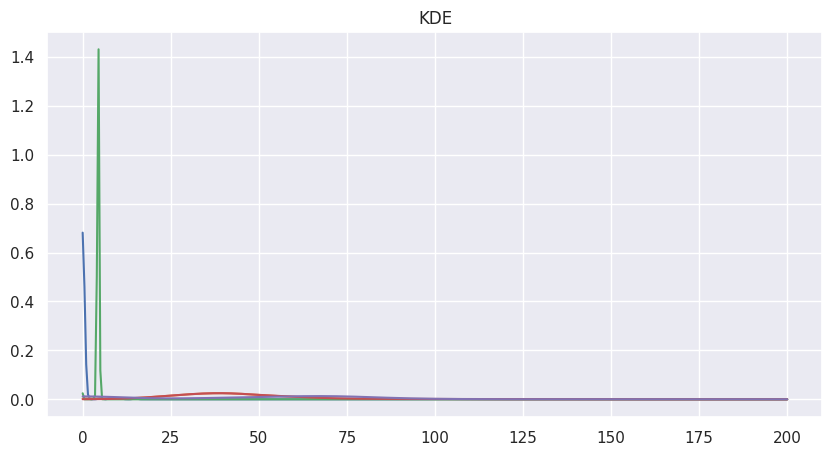

In [41]:
x = np.linspace(0, 200, 400)

plt.figure(figsize=(10, 5))
plt.title("KDE")
plt.plot(x, coupon_discount_kde.evaluate(x))
plt.plot(x, product_price_kde.evaluate(x))
plt.plot(x, product_star_rating_kde.evaluate(x))
plt.plot(x, product_minimum_offer_price_kde.evaluate(x))
plt.plot(x, product_original_price_kde.evaluate(x))
plt.show()

In [42]:
kde_estimations = {
    "coupon_discount": coupon_discount_kde.evaluate(x),
    "product_price": product_price_kde.evaluate(x),
    "product_star_rating": product_star_rating_kde.evaluate(x),
    "product_minimum_offer_price": product_minimum_offer_price_kde.evaluate(x),
    "product_original_price": product_original_price_kde.evaluate(x),
    "product_num_ratings": product_num_ratings_kde.evaluate(x)
}

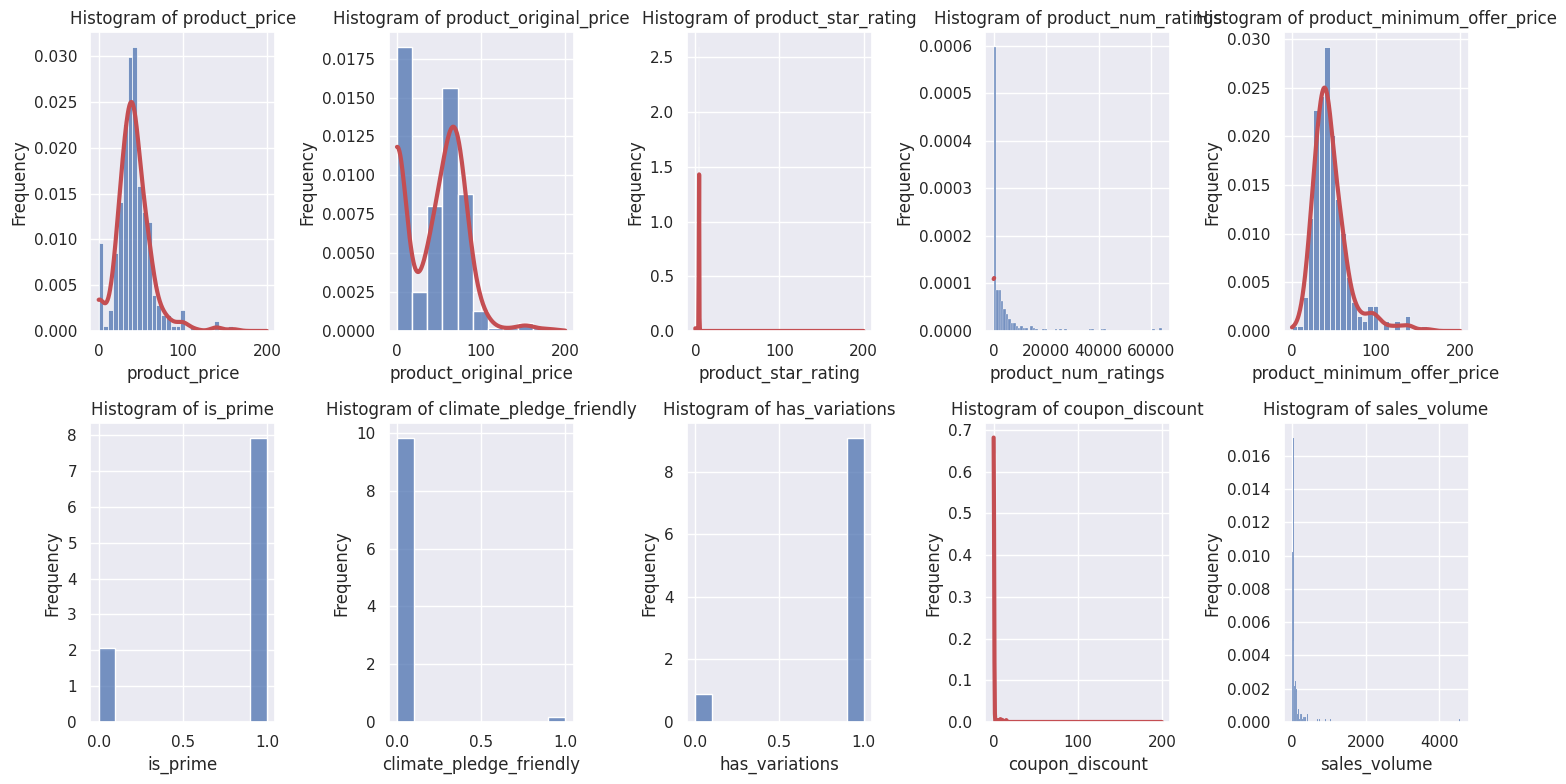

In [43]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))  # Tamaño ajustado para la cuadrícula
axes = axes.ravel()  # Convertimos los ejes a un array 1D para iterar fácilmente

# Iterar sobre las columnas y graficar los histogramas
for i, column in enumerate(df.select_dtypes(include='number').columns):
    #axes[i].hist(df[column], bins=30, color="b")
    sns.histplot(data=df, x=column, stat="density", ax=axes[i])
    if column in kde_estimations.keys():
        axes[i].plot(x, kde_estimations[column], color="r", linewidth=3.0)
        
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Eliminar cualquier gráfico vacío (si hay más espacios que columnas)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [44]:
sample = product_original_price_kde.resample(size=100)
data = df["product_original_price"].to_numpy()

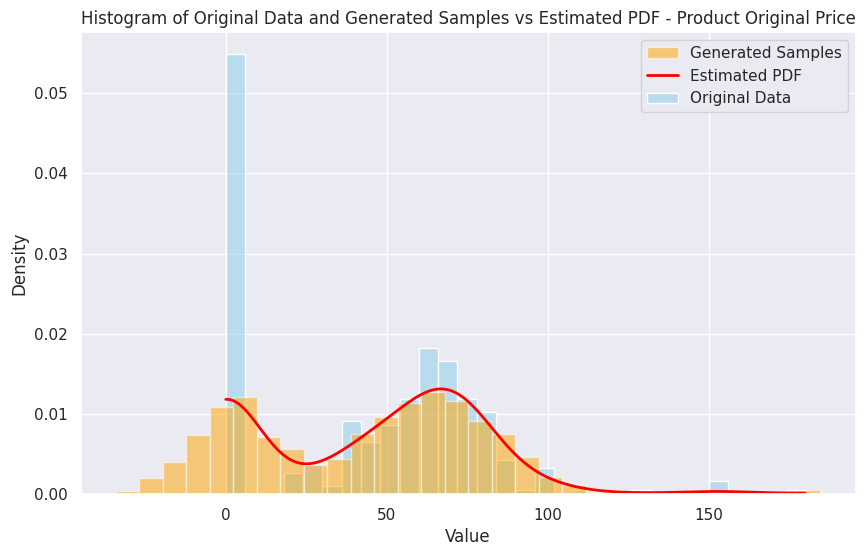

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

# Suppose you have data in the DataFrame `df` in the column `product_original_price`
data = df["product_original_price"].to_numpy()

# Create the KDE estimation
kde = gaussian_kde(data)
sample = kde.resample(1000).flatten()  # Generate samples from the KDE distribution

# Generate a sequence of values to plot the estimated PDF
x_vals = np.linspace(min(data), max(data), 1000)
pdf_vals = kde(x_vals)

# Create the visualization
plt.figure(figsize=(10, 6))

# Histogram of the original data
sns.histplot(data, bins=30, kde=False, color='skyblue', label='Original Data', stat="density", alpha=0.5)

# Histogram of the generated samples
plt.hist(sample, bins=30, density=True, alpha=0.5, label='Generated Samples', color='orange')

# Line of the estimated PDF over the original data
plt.plot(x_vals, pdf_vals, color='red', linewidth=2, label='Estimated PDF')

# Add legends and labels
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.title('Histogram of Original Data and Generated Samples vs Estimated PDF - Product Original Price')
plt.show()


In [46]:
hypotheses


,variable_name,hypothesize_distribution,result
0,product_price,non-symmetric bimodal,None
1,product_original_price,symmetric bimodal,None
2,product_star_rating,normal,False
3,product_num_ratings,exponential,False
4,product_minimum_offer_price,normal,False
5,is_prime,bernouilli,True
6,climate_pledge_friendly,bernouilli,True
7,has_variations,bernouilli,True
8,coupon_discount,multinomial,None


## Save the results

In [47]:
hypotheses[hypotheses["result"]==True]

,variable_name,hypothesize_distribution,result
5,is_prime,bernouilli,True
6,climate_pledge_friendly,bernouilli,True
7,has_variations,bernouilli,True


In [ ]:
hypotheses["variable_name"]

0                  product_price
1         product_original_price
2            product_star_rating
3            product_num_ratings
4    product_minimum_offer_price
5                       is_prime
6        climate_pledge_friendly
7                 has_variations
8                coupon_discount
Name: variable_name, dtype: object

In [49]:
distributions = [
    {
        "random_variable": "product_price",
        "kind": "non-parametric",
        "scipy_pdf_obj": product_price_kde
    },
    {
        "random_variable": "product_original_price",
        "kind": "non-parametric",
        "scipy_pdf_obj": product_original_price_kde
    },
    {
        "random_variable": "product_star_rating",
        "kind": "non-parametric",
        "scipy_pdf_obj": product_star_rating_kde
    },
    {
        "random_variable": "product_num_ratings",
        "kind": "non-parametric",
        "scipy_pdf_obj": product_num_ratings_kde
    },
    {
        "random_variable": "product_minimum_offer_price",
        "kind": "non-parametric",
        "scipy_pdf_obj": product_minimum_offer_price_kde
    },
    {
        "random_variable": "is_prime",
        "kind": "parametric",
        "scipy_pdf_obj": stats.bernoulli(df["is_prime"].to_numpy().mean())
    },
    {
        "random_variable": "climate_pledge_friendly",
        "kind": "parametric",
        "scipy_pdf_obj": stats.bernoulli(df["climate_pledge_friendly"].to_numpy().mean())
    },
    {
        "random_variable": "has_variations",
        "kind": "parametric",
        "scipy_pdf_obj": stats.bernoulli(df["has_variations"].to_numpy().mean())
    },
    {
        "random_variable": "coupon_discount",
        "kind": "non-parametric",
        "scipy_pdf_obj": coupon_discount_kde
    },
]

In [56]:
# Save the results

import joblib

with open("../data/distributions/distributions.pkl", "wb") as f:
    joblib.dump(distributions, f)